In [2]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from dataclasses import replace
import torch
import matplotlib.pyplot as plt

import utils
from utils.augmentations import get_default_transform
from utils import creating_dataset

from abcidatasets import Dataset, DatasetVariable
from omen import OMEN
import pandas as pd
import numpy as np
import sys
from loguru import logger


logger.remove()
logger.add(sys.stderr, level=1);


## custom dataset loading

In [22]:
DATA_PATH = "/Users/federicoclaudi/Downloads/dataset_v2_blocks"

data_paths = dict(
    datasets=[DATA_PATH],
    hand_type = ['left', 'right'], # [left, 'right']
    human_type = ['health'], # 'amputant'], # [amputant, 'health']
    test_dataset_list = ['fedya_tropin_standart_elbow_left'],  # don't change this !
    random_sampling=False,
    # down_sample_target=None,
)

# get transforms
p_transform = 0.1  # probability of applying the transform
transform = get_default_transform(p_transform)

# define a config object to keep track of data variables
data_config = creating_dataset.DataConfig(**data_paths)

train_paths, val_paths = utils.creating_dataset.get_train_val_pathes(data_config)


train_config = replace(data_config, samples_per_epoch=int(data_config.samples_per_epoch / len(train_paths)))               
val_config = replace(data_config, random_sampling=False, samples_per_epoch=None)

print(f"Found {len(train_paths)} training paths and {len(val_paths)} validation paths")


Found 20 training paths and 0 validation paths


In [54]:
n_inputs, n_outputs = 8, 20

dt = int(1000/200) * train_config.down_sample_target
variables = [DatasetVariable(f'target_{i}', 'hand', False) for i in range(n_outputs)]
omen_ds =  Dataset('hand', '', -1, dt, 1, variables, [])


In [53]:
dt

5

In [57]:
def ds_to_session(name, myo_session_data, omen_ds):
    train_Xs = np.concatenate([x[:, ::train_config.down_sample_target] for x, _ in myo_session_data], axis=1)
    train_Ys = np.concatenate([y for _, y in myo_session_data], axis=1)
    print(train_Xs.shape, train_Ys.shape)

    data = {}
    for i in range(n_inputs):
        data[f"myo_{i}"] = train_Xs[i]
    for i in range(n_outputs):
        data[f"target_{i}"] = train_Ys[i]
    data = pd.DataFrame(data)
    data.reset_index(drop=True, inplace=True)
    data['time'] = np.arange(data.shape[0]) * dt


    sess = omen_ds.session_from_df(
        data, 'hand', name, variables, dt, unit_prefix='myo_', trial_duration_seconds=2
    )
    sess.train_trials = sess.all_trials  # we're only using the training set to create the session so this is ok
    omen_ds.sessions.append(sess)
    return sess

Number of moves: 135 | Dataset: alex_kovalev_standart_elbow_left
Reorder this dataset alex_kovalev_standart_elbow_left True
(8, 47424) (20, 47424)
Added session alex_kovalev_standart_elbow_left with 948 trials


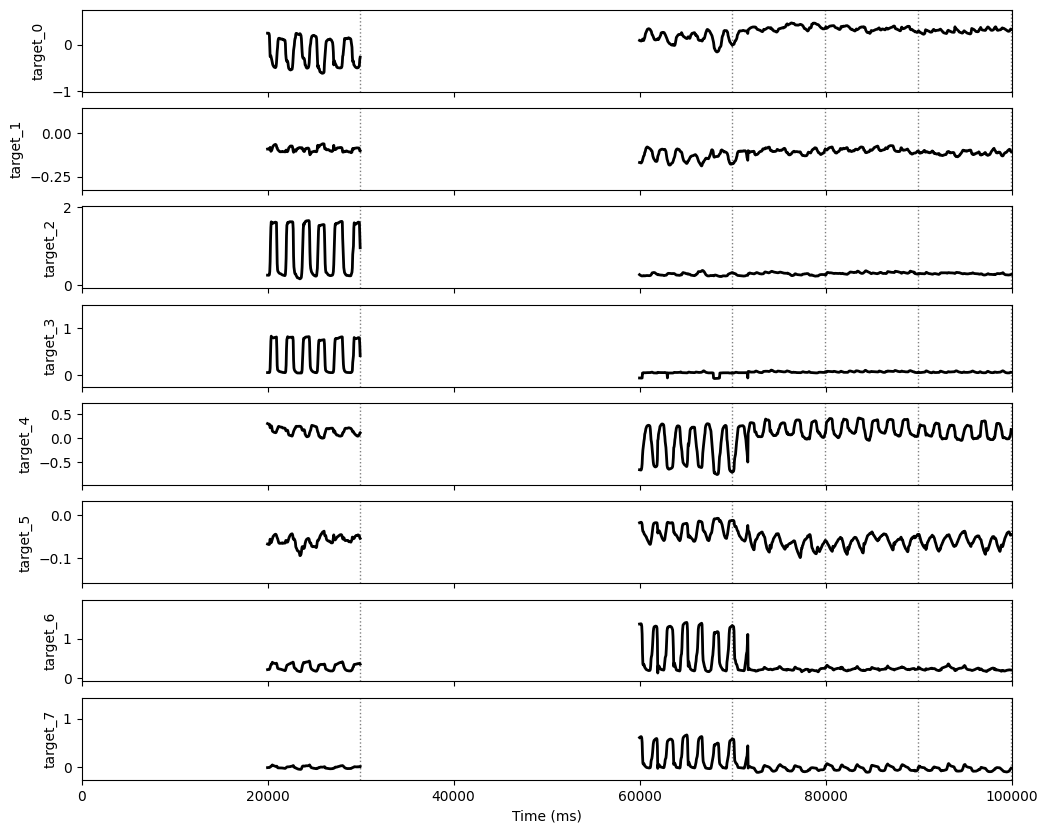

In [59]:



for path in train_paths:
    name = path.parent.parent.name
    ds = utils.creating_dataset.init_dataset(train_config, path, transform=transform)
    sess = ds_to_session(name, ds, omen_ds)
    print(f"Added session {name} with {sess.n_train_trials} trials")
    
    break

_, ax = omen_ds.sessions[0].visualize(max_n_trials=30);
ax.set(xlim=[0, 1e5]);

# Train OMEN

Train OMEN

2024-07-29 21:02:51.465 | DEBUG_LOW | omen.omen:build:67 - Building OMEN - encoder input dimension: 8
2024-07-29 21:02:51.490 | DEBUG    | omen.omen:fit_session:249 - Fitting OMEN with a single session: alex_kovalev_standart_elbow_left
2024-07-29 21:02:51.493 | DEBUG_LOW | omen.lookup.lut:on_fit_start:90 - Fitting Y scalers on 47250 samples - 20 dimensions | 1 sessions
2024-07-29 21:02:51.501 | DEBUG_LOW | omen.lookup.session:populate:93 - Populating alex_kovalev_standart_elbow_left session lookup.
2024-07-29 21:02:52.414 | DEBUG    | omen.train.base_trainer:__init__:51 - 
Trainer SingleSessionTrainer created with 
LUT(n sessions: 1, embedding size: 256)
	* alex_kovalev_standart_elbow_left 
and
Portent
	Encoder: tCNN: 8 |> 64 > 64 |> 32 -  leaky_relu, 1 kernels, kernel_size: 1
	Heads:
		0: MLP: 32 |> 48 |> 48 - leaky_relu
		1: MLP: 32 |> 48 |> 48 - leaky_relu
		2: MLP: 32 |> 48 |> 48 - leaky_relu
		3: MLP: 32 |> 48 |> 48 - leaky_relu
		4: MLP: 32 |> 48 |> 48 - leaky_relu
		5: MLP: 32 |

Output()

2024-07-29 21:02:52.506 | TENSORS  | omen.debug:log_tensor:33 - tCNN input: Tensor: torch.Size([25, 1890, 8]) - device: cpu
2024-07-29 21:02:52.513 | TENSORS  | omen.debug:log_tensor:33 - tCNN conv1: Tensor: torch.Size([25, 1890, 8]) - device: cpu
2024-07-29 21:02:52.577 | TENSORS  | omen.debug:log_tensor:33 - tCNN output: Tensor: torch.Size([25, 1890, 32]) - device: cpu


2024-07-29 21:10:11.785 | DEBUG_LOW | omen.train.base_trainer:train:180 - Training interrupted
2024-07-29 21:10:11.811 | GPU      | omen.train.device_manager:unload:82 - Unloading all models



=== OMEN ===
Portent: Portent
	Encoder: tCNN: 8 |> 64 > 64 |> 32 -  leaky_relu, 1 kernels, kernel_size: 1
	Heads:
		0: MLP: 32 |> 48 |> 48 - leaky_relu
		1: MLP: 32 |> 48 |> 48 - leaky_relu
		2: MLP: 32 |> 48 |> 48 - leaky_relu
		3: MLP: 32 |> 48 |> 48 - leaky_relu
		4: MLP: 32 |> 48 |> 48 - leaky_relu
		5: MLP: 32 |> 48 |> 48 - leaky_relu
		6: MLP: 32 |> 48 |> 48 - leaky_relu
		7: MLP: 32 |> 48 |> 48 - leaky_relu
		8: MLP: 32 |> 48 |> 48 - leaky_relu
		9: MLP: 32 |> 48 |> 48 - leaky_relu
		10: MLP: 32 |> 48 |> 48 - leaky_relu
		11: MLP: 32 |> 48 |> 48 - leaky_relu
		12: MLP: 32 |> 48 |> 48 - leaky_relu
		13: MLP: 32 |> 48 |> 48 - leaky_relu
		14: MLP: 32 |> 48 |> 48 - leaky_relu
		15: MLP: 32 |> 48 |> 48 - leaky_relu
		16: MLP: 32 |> 48 |> 48 - leaky_relu
		17: MLP: 32 |> 48 |> 48 - leaky_relu
		18: MLP: 32 |> 48 |> 48 - leaky_relu
		19: MLP: 32 |> 48 |> 48 - leaky_relu

CANs:
	0: CAN Line > Cell(N: 48, beta: 1.0000, sigma: 0.2500, tau: 1.5)
	1: CAN Line > Cell(N: 48, beta: 1.0000, s

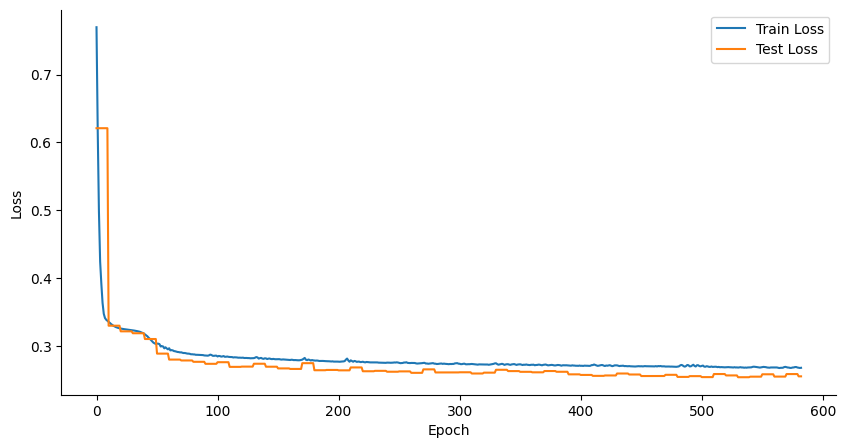

In [60]:
omen_config = dict(
    activation= 'leaky_relu',
    beta= 1.0,
    embedding_dim= 32,
    head_n_layers= 1,
    input_sigma= 0.25,
    kernel_size= 1,
    lr= 0.01,
    n_epochs= 2_000,
    n_hidden= 64,
    n_kernels= 1,
    n_layers= 2,
    sigma= 0.25,
)


betas = [4, 8, 8, 4, 4, 4, 4, 4]
sigmas = [1, 1, 1, 1, 0.5, 1, 1, 0.5]

# create and fit
omen = OMEN.from_config(omen_config)
omen.fit_session(
    omen_ds.sessions[0], plot_history=True, verbose=True, should_refine=False
)

# refine CAN hps
# for i, (beta, sigma) in enumerate(zip(betas, sigmas)):
#     omen.cans[i].initial_params = {'beta': beta, 'sigma': sigma}
#     omen.cans[i].cell.tau = 1.2

# omen.refine_cans(verbose=True)
omen

2024-07-29 21:10:23.415 | DEBUG_LOW | omen.omen:predict_session:264 - Predicting session alex_kovalev_standart_elbow_left - train


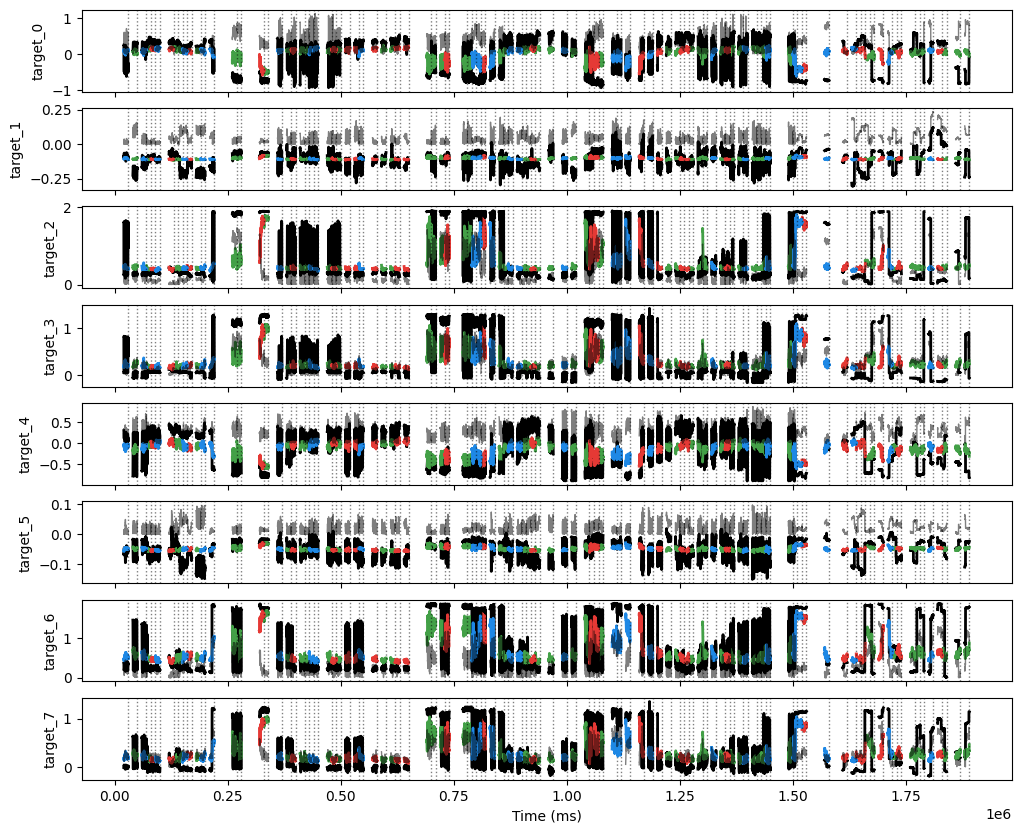

In [61]:
omen.predict_session(omen_ds.sessions[0], trial_set='train')
omen_ds.sessions[0].visualize(max_n_trials=50);

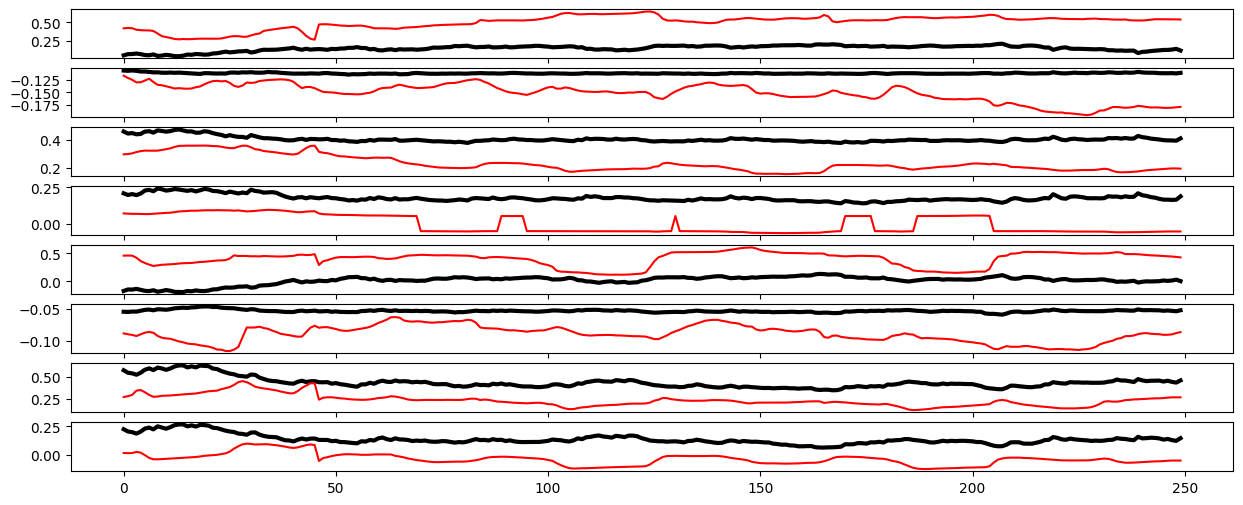

In [66]:
trial = omen_ds.sessions[0].train_trials[5]


n_to_plot=8

sd = omen.lut[omen_ds.sessions[0].name]
trial.Ypred = omen.predict(
    sd.on_predict_start(
                    trial.X, do_ue=False
                )
)

f, axes = plt.subplots(n_to_plot, 1, figsize=(15, 6), sharex=True)

for i in range(n_to_plot):
    axes[i].plot(trial.Ypred[:, i], label='pred', color='k', lw=3)
    axes[i].plot(trial.Y[:, i], label='true', color='r')
